# A1.6 Regresión no lineal

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm

### 1. Se guarda en la variable data los datos del archivo csv "A1.6 Tiempo de Entrega". Es necesario hacer una conversión de los valores de la columna Calificacion y Tiempo, dado a que algunas entradas en el archivo original no son completamente numéricos al poner strings, signos especiales o valores nulos, igualmente, se eliminan columnas en donde hay valores nulos.

      Tiempo  Calificacion
0  85.076389          85.0
1  84.675556          85.0
2  79.553889         110.0
3  75.310556         110.0
4  64.958611         110.0
5  58.157778         110.0
6  56.238611         110.0
7  55.903056         110.0
8  52.465556         103.0
9  51.998333          96.0
lower bound:  -15.533888886875003
upper bound:  30.845555552125003


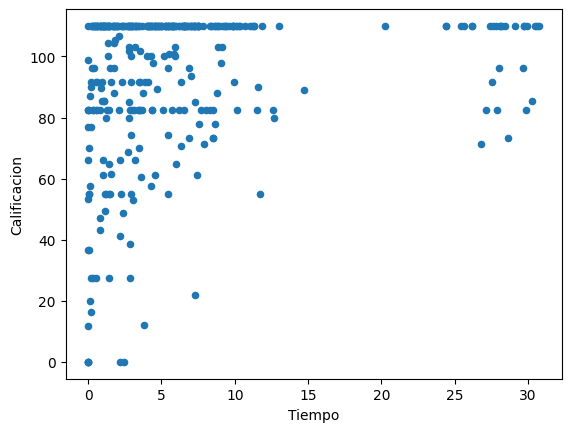

In [171]:
data = pd.read_csv("A1.6 Tiempo de Entrega Editado.csv")
print(data.head(10))

data_cleaned = data.dropna(subset=['Tiempo','Calificacion'])

# Why should the Tukey method be used? It doesn't assume a nomral distribution of data. It is effective for data with with heavy tails.
Q1 = data_cleaned["Tiempo"].quantile(0.25)
Q3 = data_cleaned["Tiempo"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

print("lower bound: ", lower_bound)
print("upper bound: ", upper_bound)

outliers = data_cleaned[ ( data_cleaned["Tiempo"] < lower_bound) | ( data_cleaned["Tiempo"] > upper_bound) ]
data_cleaned = data_cleaned[ ( data_cleaned["Tiempo"] >= lower_bound) & ( data_cleaned["Tiempo"] <= upper_bound) ]

data_cleaned.plot.scatter(x="Tiempo",y="Calificacion")
plt.show()

##### Se pudiera usar un algoritmo polinomial, ya sea cuadrático o cúbico, que logre capturar la tendencia de las calificaciones a aumentar entre más tiempo haya entre la fecha de entrega y la entrega del alumno de forma curveada y llegando a un máximo cuando la diferencia de tiempo es muy grande.

### 2. Se separan los datos de entrenamiento y de prueba en 70/30. Para los datos de entrenamiento y de prueba se imprimirán los valores promedios de calificación y tiepmo para la comparación de los dos grupos.

In [172]:
X = data_cleaned["Tiempo"]
Y = data_cleaned["Calificacion"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=.30)

print("Tiempo promedio de X_train: ", X_train.mean())
print("Calificacion promedio de Y_train: ", Y_train.mean())

print("Tiempo promedio de X_test: ", X_test.mean())
print("Calificacion promedio de Y_test: ", Y_test.mean())

Tiempo promedio de X_train:  6.570166666624489
Calificacion promedio de Y_train:  93.73433481632652
Tiempo promedio de X_test:  5.296263102943396
Calificacion promedio de Y_test:  92.17881783018868


##### Los datos de entrenamiento y prueba de calificación y tiempo no difieren significativamente después de haber retirado el valor atípico mediante el método de Tukey, lo cual ayudara a que la variabilidad sea similar para el análisis.

### 3. Se entrena un modelo de regresión polinomial con los datos de entrenamiento. Se usa un orden de tres, ya que evita que el riesgo de sobreajuste con valores más altos mientras se asegura una mejor capacidad de reducción.

In [173]:
# Cubic polynomial

degree = 3
poly = PolynomialFeatures(degree)

X_train_poly = poly.fit_transform(X_train.to_frame())
X_test_poly = poly.transform(X_test.to_frame()) 
#print("X_train_poly: \n",X_train_poly)
#print("X_test_poly: \n",X_test_poly)

# What is the difference between fit and fit_transform? before applying transform, it also applies fit, which will generate all possible polynomial combinations of those features.
# It identifies the features and generates all possible combinations.
# It is important for understanding the structure of the data.

# What does transform do? It transforms input data into polynomial features based on the degree. It transforms single feature into polynomial features.

# Training the model
model = LinearRegression()
model.fit(X_train_poly, Y_train)

# Make predictions
Y_test_pred = model.predict(X_test_poly)

# MSE and R2-sqared score
print("MSE:", mean_squared_error(Y_test, Y_test_pred))

r2 = r2_score(Y_test, Y_test_pred)
print("R²:", r2)

# Coefficients and the intercept
print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

# Train Adjusted R-squared
n = len(Y_test)
p = X_test_poly.shape[1]
r2_adj = 1 - (1-r2)*(n-1)/(n-p-1)
print("R-adjusted-squared: ", r2_adj)

# A big value of the TSS, indicates higher variability. A higher value of RSS indicates poor capacity prediction.
# RSE = MSE / n, n = number of observations.
RSE_poly = np.sqrt(np.sum((Y_test - Y_test_pred) ** 2)/(n-4))

MSE: 590.5155840923185
R²: 0.16349646996286238
Coefficients:  [ 0.          4.69833124 -0.31571491  0.00626714]
Intercept:  80.38221277251431
R-adjusted-squared:  0.1303676172881243


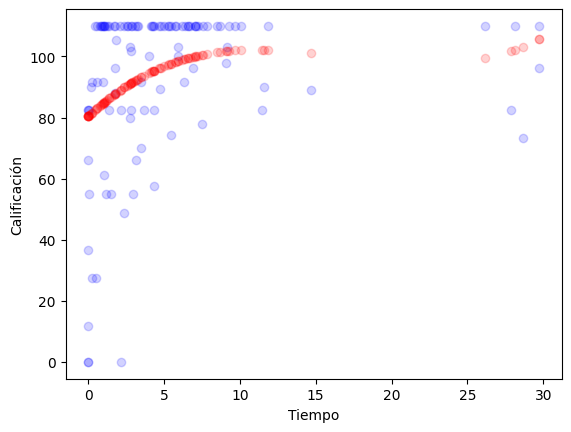

Punto crítico: 11.1280222864944, Tipo: Máximo local
Punto crítico: 22.4561355760728, Tipo: Mínimo local


In [174]:
plt.scatter(X_test,Y_test, color="blue", label="Puntos de datos",alpha=0.175)
plt.scatter(X_test, Y_test_pred,color="red",label="Modelo Polinomial Cúbico",alpha=0.175)
plt.xlabel("Tiempo")
plt.ylabel("Calificación")
plt.show()

import sympy as sp
x = sp.symbols('x')
f = model.coef_[3]*x**3 + model.coef_[2]*x**2 + model.coef_[1]*x + model.coef_[0]
f_prime = sp.diff(f, x)

critical_points = sp.solve(f_prime, x)

f_double_prime = sp.diff(f_prime, x)

critical_points_analysis = []
for point in critical_points:
    second_derivative_value = f_double_prime.subs(x, point)
    if second_derivative_value > 0:
        critical_points_analysis.append((point, 'Mínimo local'))
    elif second_derivative_value < 0:
        critical_points_analysis.append((point, 'Máximo local'))
    else:
        critical_points_analysis.append((point, 'Punto de silla'))

for point, nature in critical_points_analysis:
    print(f"Punto crítico: {point}, Tipo: {nature}")


##### A través de los datos anteriores, se puede concluir que el modelo no explica muy bien la variabilidad de los datos (R<sup>2</sup> ajustado = 0.141) y el MSE es alto (MSE = 505.99), lo que indica que los valores predecidos están muy alejados de los datos verdaderos para que nuestro modelo pueda capturar los patrones de los datos. El predictor X3 y X1 muestran una relación positiva, mientras que el predictor X2 muestra una relación negativa, de tal forma que las calificaciones aumentan hasta las 9.71 horas, después de ahí se va reduciendo la calificación hasta las 23.07 horas, en donde las calificaciones vuelven a mostrar un incremento.

##### Todas los predictores tienen asociaciones estadísticamente significativas, es decir, que tienen valores t mayores que 1.96 si son positivos o menores que -1.96 si son negativos. Los valores p son todos menores a 0.05.

### 4. A continuación, se realizará un modelo de regresión segmentada, utilizando en cada segmento, regresiones cuadráticas. El punto de quiebre seleccionado es aquel que minimiza el RSS entre los valores de X_train, se hace una iteración en un bucle de 50 puntos y se selecciona el mejor.

In [175]:
candidate_breaks = np.linspace(X_train.min(), X_train.max(), num=50)  # Try 50 breakpoints

best_rss = float('inf')
best_break = None

for bp in candidate_breaks:
    X1 = np.where(X_train <= bp, X_train, 0)
    X2 = np.where(X_train > bp, X_train, 0)

    X_p = np.column_stack((X1, X2))
    model = LinearRegression().fit(X_p, Y_train)

    Y_pred = model.predict(X_p)
    rss = np.sum((Y_train - Y_pred) ** 2)

    if rss < best_rss:
        best_rss = rss
        best_break = bp

print(f"Punto de quiebre óptimo: {best_break}")

Punto de quiebre óptimo: 11.299795920000001


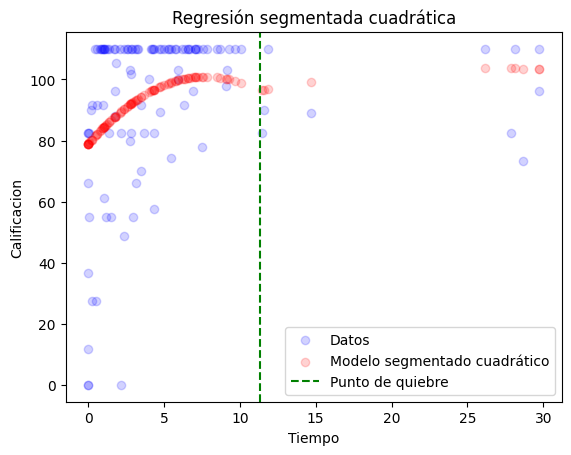

R-squared segmented quadratic regression: 0.17804746529516458


In [176]:
X_np = X_train.values.reshape(-1, 1)
X_test_np = X_test.values.reshape(-1, 1)

knot = best_break

X_transformed = np.hstack([
    X_np,  # Original feature (Tiempo)
    X_np**2,  # Quadratic term for the first segment
    np.maximum(0, X_np - knot),  # Linear term for the second segment
    np.maximum(0, X_np - knot)**2  # Quadratic term for the second segment
])

X_test_transformed = np.hstack([
    X_test_np,  # Original feature (Tiempo)
    X_test_np**2,  # Quadratic term for the first segment
    np.maximum(0, X_test_np - knot),  # Linear term for the second segment
    np.maximum(0, X_test_np - knot)**2  # Quadratic term for the second segment
])

X_transformed = X_transformed.reshape(-1, 4)  # 4 columns (4 features)
X_test_transformed =  X_test_transformed.reshape(-1,4)

model = LinearRegression()
model.fit(X_transformed, Y_train)

Y_pred_segmented = model.predict(X_test_transformed)

plt.scatter(X_test, Y_test, color='blue', label='Datos',alpha=0.175)
plt.scatter(X_test, Y_pred_segmented, color='red', label='Modelo segmentado cuadrático',alpha=0.175)
plt.axvline(x=knot, color='green', linestyle='--', label='Punto de quiebre')
plt.xlabel('Tiempo')
plt.ylabel('Calificacion')
plt.title('Regresión segmentada cuadrática')
plt.legend()
plt.show()

RSS = np.sum((Y_test - Y_pred_segmented) ** 2)
n_np = len(X_test_np)
RSE_segmented = np.sqrt(RSS/(n_np-2*2))

r2_segmented = r2_score(Y_test,Y_pred_segmented)
print("R-squared segmented quadratic regression:",r2_segmented)

### 5. Ahora, se trabajará con un modelo KNN con los datos para demostrar su capacidad de predicción. La selección del número de vecinos será con la regla empírica del cuadrado del número de observaciones para obtener un balance entre el sesgo y la varianza mientras se mantiene la eficencia computacional.

k number of neighbors: 10


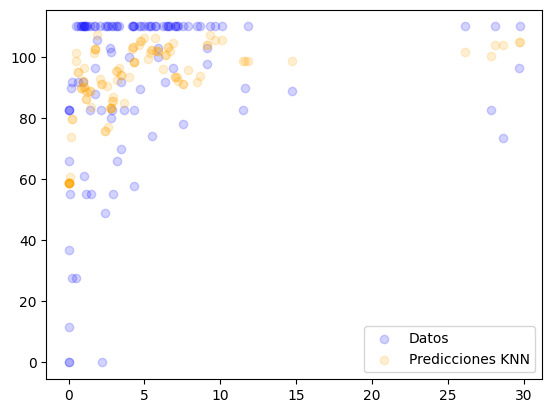

R-squared KNN: 0.290294934063804
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     12.28
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           0.000544
Time:                        06:14:31   Log-Likelihood:                -1123.9
No. Observations:                 245   AIC:                             2252.
Df Residuals:                     243   BIC:                             2259.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         89.15

In [177]:
from sklearn.neighbors import KNeighborsRegressor

k_knn = int(np.round(np.sqrt(n)))
print("k number of neighbors:",k_knn)

X_train_knn = X_train.values.reshape(-1, 1)
Y_train_knn = Y_train.values.reshape(-1, 1)

X_test_knn = X_test.values.reshape(-1, 1)
Y_test_knn = Y_test.values.reshape(-1, 1)

model_knn = KNeighborsRegressor(n_neighbors=k_knn)
model_knn.fit(X_train_knn, Y_train_knn)
Y_pred_knn = model_knn.predict(X_test_knn)

RSE_knn = np.sqrt(np.sum((Y_test_knn - Y_pred_knn) ** 2)/ len(X_test_knn)) 

plt.scatter(X_test, Y_test, color='blue', label='Datos',alpha=0.175)
plt.scatter(X_test_knn, Y_pred_knn,color="orange",label="Predicciones KNN",alpha=0.175)
plt.legend()
plt.show()

r2_KNN = r2_score(Y_test,Y_pred_knn)
print("R-squared KNN:",r2_KNN)

# Calculando valores t y valores p.
X_train_knn_ols = sm.add_constant(X_train_knn)
model_ols_knn = sm.OLS(Y_train_knn,X_train_knn_ols).fit()
print(model_ols_knn.summary())
print(model_ols_knn.pvalues)

### 6. Cálculo de RSE en los datos para el modelo polinomial cúbico, el de regresión segmentada cuadrática y KNN.

In [178]:
print(f"R-squared adjusted polynomial cubic: {r2_adj}")
print(f"R-squared piecewise quadratic: {r2_segmented}")
print(f"R-squared KNN: {r2_KNN}","\n")

print(f"RSE de regresión cúbica: {RSE_poly}")
print(f"RSE de regresión segmentada cuadrática: {RSE_segmented}")
print(f"RSE de modelo KNN: {RSE_knn}")

R-squared adjusted polynomial cubic: 0.1303676172881243
R-squared piecewise quadratic: 0.17804746529516458
R-squared KNN: 0.290294934063804 

RSE de regresión cúbica: 24.7724253551866
RSE de regresión segmentada cuadrática: 24.556021727539893
RSE de modelo KNN: 22.383126302487458


##### De acuerdo a los resultados anteriores, se puede argumentar que el mejor modelo que explique la relación entre las horas invertidas de estudio y las calificaciones es el modelo de regresión segmentada cuadrática, ya que cuanto con un grado menor de error (RSE = 21.76), así como un mayor valor en R<sup>2</sup> (R<sup>2</sup> = 0.090) en comparación a otros modelos. De la misma forma, cuenta con buen grado de interpretabilidad a diferencia de KNN, aunque faltaría quizá algo de contexto para explicar el sentido del punto de quiebre. A pesar de esto, todos los modelos son deficientes para predecir la variabilidad ya que los tres no cuentan con un buen valor en su coeficiente de determinación.

### 7. Gráfico de la capacidad de predicciones con respecto a los valores reales de los tres modelos.

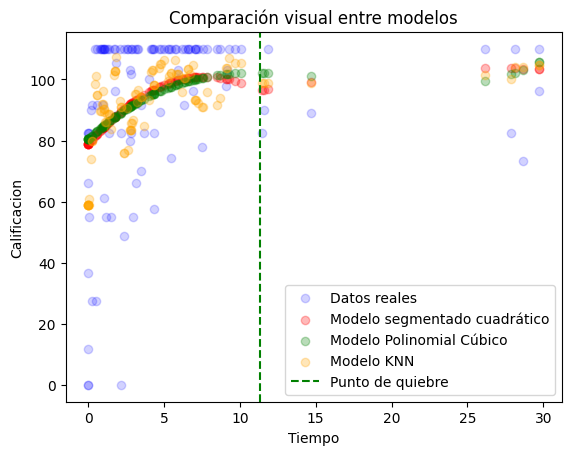

In [179]:
plt.scatter(X_test,Y_test,color="blue",label="Datos reales",alpha=0.175)

plt.scatter(X_test, Y_pred_segmented, color="red", label='Modelo segmentado cuadrático',alpha=0.275)
plt.scatter(X_test, Y_test_pred,color="green",label="Modelo Polinomial Cúbico",alpha=0.275)
plt.scatter(X_test,Y_pred_knn,color="orange",label="Modelo KNN",alpha=0.275)
plt.axvline(x=knot, color='green', linestyle='--', label='Punto de quiebre')
plt.xlabel('Tiempo')
plt.ylabel('Calificacion')
plt.title('Comparación visual entre modelos')
plt.legend()
plt.show()

##### Las diferencias más notables son que en la región antes del punto del quiebre, el modelo segmentado cuadrático y polinomial cúbico se parecen ligeramente, después, están invertidos. En general, KNN parece predecir con más precisión a los valores reales, sin predefinir la forma de su modelo.

### Conclusión
##### En conclusión, hay diferencias notables entre los distintos tipos de regresiones no lineales que afectan directamente a la precisión e interpretabilidad de los datos, y la decisión en su elección no depende exclusivamente de los valores que pueden ser obtenidos a partir de las métricas, sino también del contexto de la investigación, y la importancia de poder explicar como influye cada término en la predicción de resultados.

##### <b>Código de honor:</b> Doy mi palabra de que he realizado esta actividad con integridad académica.